In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import requests

In [3]:
def add_adx(data):
    UpMove = data["High"] - data["High"].shift(1)
    DownMove = data["Low"].shift(1) - data["Low"]
    
    pDM = np.where((UpMove > DownMove) and (UpMove > 0),UpMove,0)
    mDM = np.where((DownMove > UpMove) and (DownMove > 0),DownMove,0)

    TR = np.max(data["High"] - data["Low"], 
    np.abs(data["High"] - data["Close"].shift(1)), 
    np.abs(data["Low"] - data["Close"].shift(1)))

    ATR = TR.rolling(14).mean()

    SpDM = (13 / 14) * pDM.rolling(14).sum() + (1 / 14) * pDM
    SmDM = (13 / 14) * mDM.rolling(14).sum() + (1 / 14) * mDM

    pDI = 100 * SpDM / ATR
    mDI = 100 * SmDM / ATR

    DX = 100 * np.abs(pDI - mDI) / np.abs(pDI + mDI)

    data["ADX"] = 0
    
    for index,row in data.iterrows():
        data.loc[index < 14,"ADX"] = data.loc[0:index,"ADX"] / (index + 1)
        data.loc[index >= 14, "ADX"] = 13 * data.loc[index-1,"ADX"] + data.loc[index,"ADX"]


    return data


In [4]:
def fear_and_greed():

    URL = "https://api.alternative.me/fng/?limit=0"
    r = requests.get(url = URL)
    fng = r.json()
    fng = pd.DataFrame(fng['data'])
    fng["timestamp"] = fng["timestamp"].astype(int)
    fng["value"] = fng["value"].astype(int)
    for index,row in fng.iterrows():
        fng.loc[index,"timestamp"] = datetime.utcfromtimestamp(fng.loc[index,"timestamp"])
        fng.loc[index,"timestamp"] = fng.loc[index,"timestamp"].strftime("%Y-%m-%d")
    fng.rename(columns={"timestamp":"Date", "value":"FnG"},inplace=True)

    return fng.drop(["time_until_update","value_classification"],axis=1)
fear_and_greed()

,FnG,Date
0,22,2022-09-22
1,23,2022-09-21
2,23,2022-09-20
3,21,2022-09-19
4,27,2022-09-18
...,...,...
1687,11,2018-02-05
1688,24,2018-02-04
1689,40,2018-02-03
1690,15,2018-02-02


In [5]:
def add_rsi(data):
    df = data.copy()

    df["Gains"] = df["Variation"] * (df["Variation"] >= 0)
    df["Losses"] = df["Variation"] * (df["Variation"] < 0)
    df["Avg Gain"] = df["Gains"].rolling(14).mean()
    df["Avg Loss"] = df["Losses"].rolling(14).mean()
    for i in range(14):
        df["Avg Gain"].loc[i] = df["Gains"][0:i].mean()
        df["Avg Loss"].loc[i] = df["Losses"][0:i].mean()

    df["Avg Loss"] = -1 * df["Avg Loss"]

    df['RSI'] = 0

    #df['RSI'] = 100 - (100 / (1 + ))
    
    df['RSI'] = 100 - (100 / (1 + df['Avg Gain'] / df['Avg Loss']))

    df = df.drop(["Gains", "Losses", "Avg Gain", "Avg Loss"],axis=1)

    #df['RSI'].loc[0:14] = 100 - (100 / (1 + df['Avg Gain'].loc[0:14] / df['Avg Loss'].loc[0:14]))


    return df

In [6]:
def add_macd(data):
    df = data.copy()

    df['MACD'] = df["Close"].ewm(span=12, adjust=False).mean() - df["Close"].ewm(span=26, adjust=False).mean()

    df['MACD_SIGNAL'] = df["MACD"].ewm(span=9, adjust=False).mean()

    df['MACD_H'] = df["MACD"] - df["MACD_SIGNAL"]

    df.drop(["MACD_SIGNAL"], axis=1, inplace=True)

    return df

In [7]:
confirmation = pd.read_csv("median-confirmation-time.csv")
confirmation

,Timestamp,median-confirmation-time
0,2009-01-09 23:00:00,0.000000
1,2009-01-12 23:00:00,0.000000
2,2009-01-15 23:00:00,0.000000
3,2009-01-18 23:00:00,0.000000
4,2009-01-21 23:00:00,0.000000
...,...,...
1661,2022-09-02 00:00:00,6.300595
1662,2022-09-05 00:00:00,7.164286
1663,2022-09-08 00:00:00,7.404167
1664,2022-09-11 00:00:00,6.991071


In [8]:
time = confirmation.loc[0,"Timestamp"]
time[:-9]

'2009-01-09'

In [9]:
def confirmation_time(data):
    df = pd.DataFrame({"Date":[],"Confirmation Time":[]})
    for i in range(len(data)):
        for j in range(3):
            date = datetime.strptime(data.loc[i,"Timestamp"][:-9],"%Y-%m-%d")
            date = date + timedelta(days=j)
            #print(str(date)[:-9])
            df = df.append({"Date":str(date)[:-9],"Confirmation Time":data.loc[i,"median-confirmation-time"]},ignore_index=True)
    return df

In [10]:
transactions = pd.read_csv("n-transactions.csv")
transactions

,Timestamp,n-transactions
0,2009-01-16 23:00:00,109
1,2009-01-19 23:00:00,115
2,2009-01-22 23:00:00,86
3,2009-01-25 23:00:00,97
4,2009-01-28 23:00:00,122
...,...,...
1659,2022-09-03 00:00:00,242597
1660,2022-09-06 00:00:00,268125
1661,2022-09-09 00:00:00,290849
1662,2022-09-12 00:00:00,268971


In [11]:
def network_transactions(data):
    df = pd.DataFrame({"Date":[], "Transactions":[]})

    for i in range(len(data)):
        for j in range(3):
            date = datetime.strptime(data.loc[i,"Timestamp"][:-9],"%Y-%m-%d")
            date = date + timedelta(days=j)
            #print(str(date)[:-9])
            df = df.append({"Date":str(date)[:-9],"Transactions":data.loc[i,"n-transactions"]},ignore_index=True)
    return df

In [12]:
def miners_revenue(data):
    df = pd.DataFrame({"Date":[], "Miners Revenue":[]})

    for i in range(len(data)):
        for j in range(3):
            date = datetime.strptime(data.loc[i,"Timestamp"][:-9],"%Y-%m-%d")
            date = date + timedelta(days=j)
            df = df.append({"Date":str(date)[:-9],"Miners Revenue":data.loc[i,"miners-revenue"]},ignore_index=True)

    return df

In [13]:
def standardize_col(data,col):
    df = data.copy()
    df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [14]:
data = pd.read_csv("BTC-USD_.csv")
data = add_adx(data)
data

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [47]:
data = pd.read_csv("BTC-USD_.csv")
data["Variation"] = (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)
data.drop("Adj Close",axis=1,inplace=True)
data = add_rsi(data)
data = add_macd(data)
data = standardize_col(data,"Volume")
data = standardize_col(data,"MACD")
data = standardize_col(data,"MACD_H")
data = standardize_col(data,"RSI")
data = standardize_col(data,"Variation")
confirmation = confirmation_time(pd.read_csv("median-confirmation-time.csv"))
transactions = network_transactions(pd.read_csv("n-transactions.csv"))
miners_revenue = miners_revenue(pd.read_csv("miners-revenue.csv"))
fear_and_greed = fear_and_greed()
data = pd.merge(data,confirmation,on="Date")
data = pd.merge(data,transactions,on="Date")
data = pd.merge(data,miners_revenue,on="Date")
data = pd.merge(data,fear_and_greed,on="Date")
data = standardize_col(data,"Confirmation Time")
data = standardize_col(data,"Transactions")
data = standardize_col(data,"Miners Revenue")
data = standardize_col(data,"FnG")
data.dropna(inplace=True)

c:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


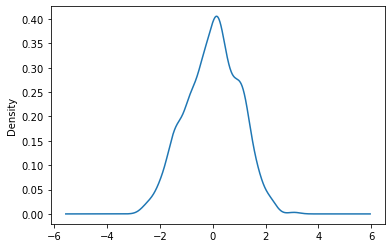

In [48]:
data["Transactions"].plot.kde()
plt.show()

In [49]:
data

,Date,Open,High,Low,Close,Volume,Variation,RSI,MACD,MACD_H,Confirmation Time,Transactions,Miners Revenue,FnG
0,2018-02-01,10237.299805,10288.799805,8812.280273,9170.540039,-0.292146,-2.712213,-1.043523,-1.108359,-0.475907,1.144750,-0.774692,-0.186892,-0.583209
1,2018-02-02,9142.280273,9142.280273,7796.490234,8830.750000,-0.152676,-1.011481,-1.204172,-1.202571,-0.654534,1.144750,-0.774692,-0.186892,-1.244407
2,2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,-0.427993,0.955604,-1.632900,-1.235294,-0.618233,1.114249,-0.774692,-0.186892,-0.142410
3,2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,-0.437581,-2.584947,-1.626830,-1.320379,-0.741794,1.114249,-1.144752,-0.264496,-0.847688
4,2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,-0.326118,-4.184569,-1.814295,-1.479953,-1.057732,1.114249,-1.144752,-0.264496,-1.420727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679,2022-09-04,19832.470703,19999.689453,19636.816406,19986.712891,0.478227,0.148948,-1.113287,-0.844382,-0.254845,-1.063067,-0.648298,-0.307825,-1.024008
1680,2022-09-05,19988.789063,20031.160156,19673.046875,19812.371094,0.658018,-0.278482,-1.133325,-0.831832,-0.166540,-0.742360,-0.648298,-0.307825,-0.891768
1681,2022-09-06,19817.724609,20155.269531,18800.171875,18837.667969,1.393318,-1.325705,-1.548973,-0.892284,-0.308652,-0.742360,-0.165203,-0.359746,-0.935848
1682,2022-09-07,18837.683594,19427.171875,18644.466797,19290.324219,0.981876,0.568952,-1.180050,-0.893278,-0.249058,-0.742360,-0.165203,-0.359746,-0.847688


In [50]:
data.to_csv("BTC-USD_SIGNALS.csv",index=False)